# Calibration of a diffraction setup using `Jupyter` notebooks
This notebook presents a very simple GUI for doing the calibration of diffraction setup within the Jupyter environment with `Matplotlib` and `Ipywidgets`.

Despite this is in the `cookbook` section, this **tutorial** requires advanced Python programming knowledge and some good understanding of `PyFAI`. 

The basic idea is to port, more or less directly, the `pyFAI-calib` interface which was done with matplotlib into the Jupyter notebook. 

The PeakPicker class has been addapted and this notebook presents mainly its usage.

Most credits go *Philipp Hans* for the adaptation of the origin PeakPicker class to Jupyter.

In [1]:
%matplotlib nbagg
import pyFAI
import logging

import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from ipywidgets import *
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.peak_picker import PeakPicker
from pyFAI.geometryRefinement import GeometryRefinement
logging.basicConfig(level=logging.INFO)
print(f"PyFAI version {pyFAI.version}")

PyFAI version 0.21.0-dev0


In [2]:
# Some parameters like the wavelength, the calibrant and the diffraction image (downloaded from internet)
wavelength = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

img = pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")
fimg = fabio.open(img)
image = fimg.data

<IPython.core.display.Javascript object>


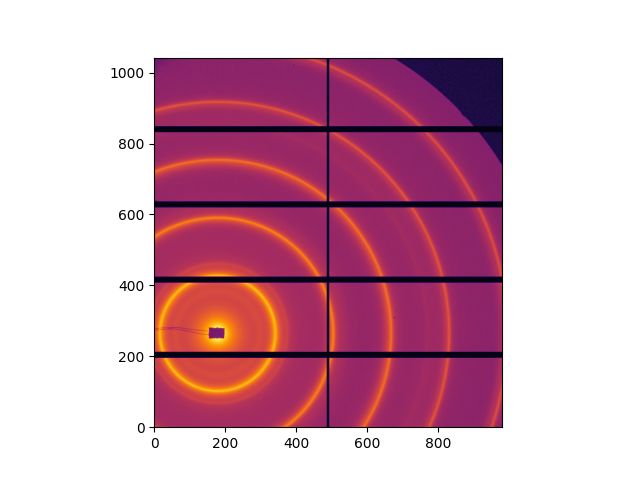

In [3]:
#Simple display of the image:
_ = jupyter.display(image)

<IPython.core.display.Javascript object>


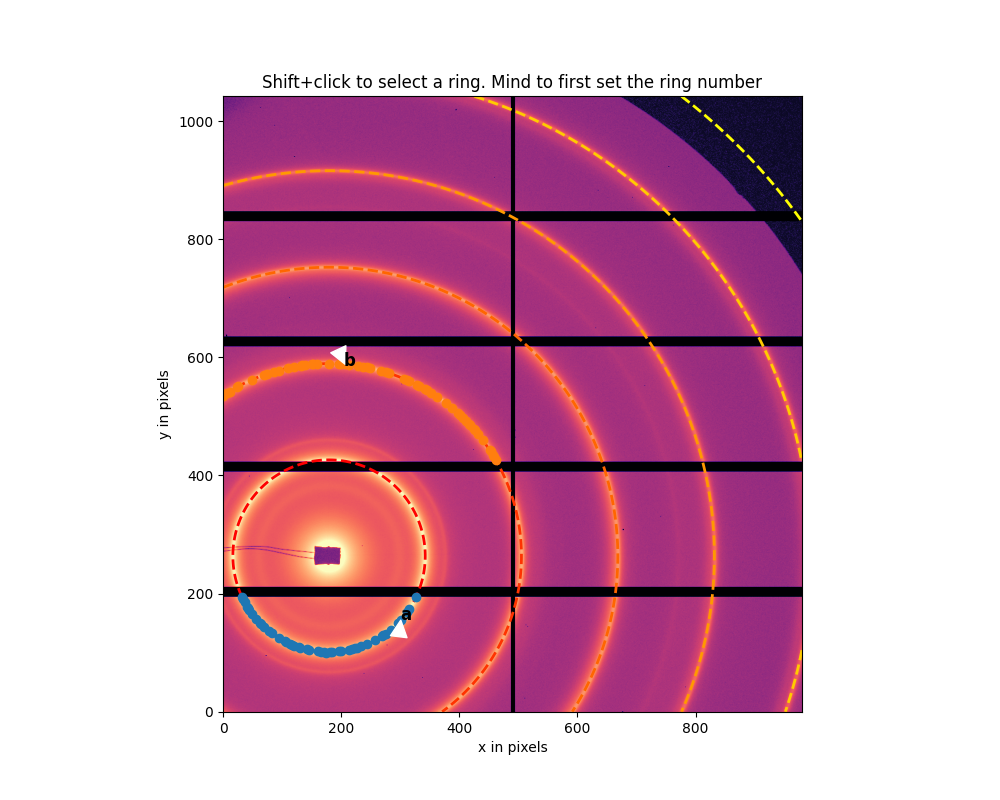

In [4]:
#PeakPicker is used in the same way as the one in the CLI.
pp = PeakPicker(data=fimg.data, calibrant=AgBh, wavelength=wavelength, detector=pilatus)
pp.gui(log=True)

In [5]:
# Display a summary of control points
pp.points

ControlPoints instance containing 2 group of point:
AgBh Calibrant with 49 reflections at wavelength 1e-10
Containing 2 groups of points:
# a ring 0: 47 points
# b ring 1: 56 points

In [6]:
gr = GeometryRefinement(pp.points.getList(), 
                        detector=pilatus, 
                        calibrant=AgBh, 
                        wavelength=wavelength)
print("Before refinement: parameters are guessed from the ellipse fitting")
print(gr)
print(f"Cost={gr.chi2()}")

Before refinement: parameters are guessed from the ellipse fitting
Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.649512e+00m	PONI= 4.400141e-02, 3.948850e-02m	rot1=0.005181  rot2= 0.001017  rot3= 0.000000 rad
DirectBeamDist= 1649.535mm	Center: x=179.892, y=265.575 pix	Tilt=0.303 deg  tiltPlanRotation= 168.895 deg
Cost=1.0758147656611738e-05


In [7]:
# Reset the detector to be normal to the incident beam
gr.rot1=0
gr.rot2=0
gr.rot3=0
print(gr)
print(f"Cost={gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.649512e+00m	PONI= 4.400141e-02, 3.948850e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1649.512mm	Center: x=229.584, y=255.822 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Cost=0.0007224479662442899


In [8]:
# Geometry refinement with some constrains
gr.refine3(fix=["wavelength", "rot1", "rot2", "rot3"])
print(gr)
print(f"Cost={gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.634918e+00m	PONI= 4.542590e-02, 3.093805e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1634.918mm	Center: x=179.872, y=264.104 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Cost=1.1190232651008802e-07


In [9]:
# Validate the calibration by overlaying the ring position 
pp.contour(gr.array_from_unit(scale=False))

Visually check that the overlaid dashed curve on the Debye-Sherrer rings of the image
Check also for correct indexing of rings
